Import used libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.tsa.stattools as ts 

/Users/Malte/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Import used data:

In [2]:
google_queries = pd.DataFrame.from_csv("Google Trends Relative Search Volume.csv")
wikipedia_pageviews = pd.DataFrame.from_csv("Wikipedia Pageview Data.csv")

Time range of Wikipedia Pageviews must match time range of Google SVI (delete unused rows): 07/05/2015 - 04/14/2018

In [3]:
dates_to_delete = list(range(0, 116))
google_queries_adjusted = google_queries.drop(dates_to_delete)
google_queries_adjusted = google_queries_adjusted.reset_index(drop=True)
google_queries_adjusted.head()

,Week,Relative Search Volume
0,2015-07-05,2
1,2015-07-12,2
2,2015-07-19,2
3,2015-07-26,2
4,2015-08-02,2


Derive Dataframe of weekly wikipedia pageviews from daily wikipedia pageviews:

In [4]:
dates_to_delete_2 = list(range(0, 4))
wikipedia_pageviews = wikipedia_pageviews.drop(dates_to_delete_2)
wikipedia_pageviews['Weekly Pageviews'] = wikipedia_pageviews['Pageviews'].groupby(np.arange(len(wikipedia_pageviews)) // 7).transform('sum')
wikipedia_pageviews_weekly = wikipedia_pageviews[wikipedia_pageviews.index % 7 == 0]
wikipedia_pageviews_weekly = wikipedia_pageviews_weekly.reset_index(drop=True)
wikipedia_pageviews_weekly = wikipedia_pageviews_weekly.drop(["Pageviews"], axis=1)
wikipedia_pageviews_weekly.head()

,Weekly Pageviews
0,66164
1,52300
2,59213
3,70532
4,63051


Join the two dataframes:

In [5]:
google_queries_and_wikipedia = pd.concat([google_queries_adjusted, wikipedia_pageviews_weekly], axis=1)
google_queries_and_wikipedia.head()

,Week,Relative Search Volume,Weekly Pageviews
0,2015-07-05,2,66164
1,2015-07-12,2,52300
2,2015-07-19,2,59213
3,2015-07-26,2,70532
4,2015-08-02,2,63051


# 1. Correlation of non-tranformed data (non-stationary)

## Linearity, homoscedasticity, skewness and kurtosis:

Check linearity and and Homoscedasticity with scatter plot:

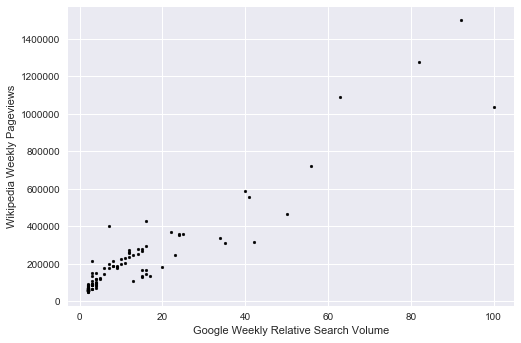

In [6]:
plt.scatter(google_queries_and_wikipedia["Relative Search Volume"],google_queries_and_wikipedia["Weekly Pageviews"],c="black", s=8)
plt.xlabel("Google Weekly Relative Search Volume")
plt.ylabel("Wikipedia Weekly Pageviews")
plt.show()

Check Distribution of Data:

Skewness:

In [7]:
stats.skew(google_queries_and_wikipedia["Relative Search Volume"])

3.478257892434215

In [8]:
stats.skew(google_queries_and_wikipedia["Weekly Pageviews"])

3.8268093926771467

Kurtosis:

In [9]:
stats.kurtosis(google_queries_and_wikipedia["Relative Search Volume"])

13.450035755558297

In [10]:
stats.kurtosis(google_queries_and_wikipedia["Weekly Pageviews"])

16.942635943704687

Show Distribution in Histogram:

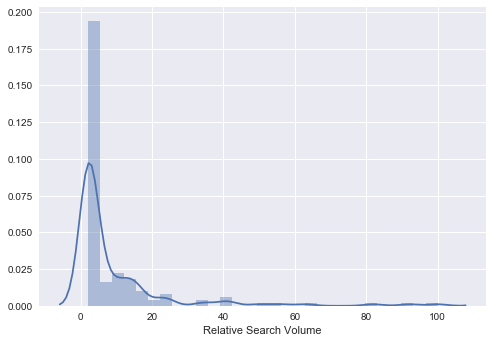

In [11]:
sns.distplot(google_queries_and_wikipedia["Relative Search Volume"])
plt.show()

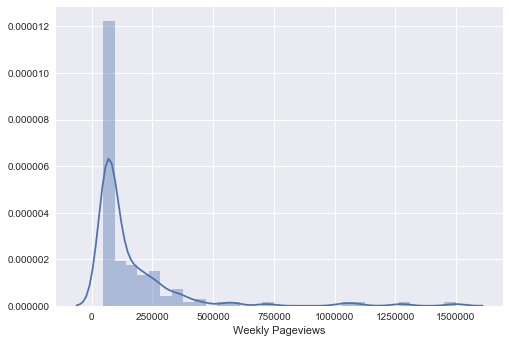

In [12]:
sns.distplot(google_queries_and_wikipedia["Weekly Pageviews"])
plt.show()

## Perform Correlation Analysis on non-transformed data

In [13]:
stats.pearsonr(google_queries_and_wikipedia["Relative Search Volume"], google_queries_and_wikipedia["Weekly Pageviews"])

(0.94505508532498395, 2.5771857320293603e-71)

# 2. Correlation of first log differences

### Calculate First Log Differences

In [14]:
google_queries_log = google_queries_and_wikipedia["Relative Search Volume"].apply(np.log)
google_queries_log_diff = google_queries_log.diff()
google_queries_log_diff = google_queries_log_diff.drop(0)
google_queries_log_diff.head()

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: Relative Search Volume, dtype: float64

In [15]:
wikipedia_pageviews_log = google_queries_and_wikipedia["Weekly Pageviews"].apply(np.log)
wikipedia_pageviews_log_diff = wikipedia_pageviews_log.diff()
wikipedia_pageviews_log_diff = wikipedia_pageviews_log_diff.drop(0)
wikipedia_pageviews_log_diff.head()

1   -0.235140
2    0.124145
3    0.174925
4   -0.112123
5   -0.164393
Name: Weekly Pageviews, dtype: float64

### Check linearity and homoscedasticity

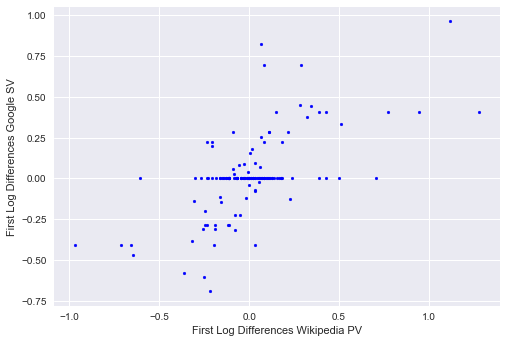

In [16]:
plt.scatter(wikipedia_pageviews_log_diff, google_queries_log_diff,c="b", s=8)
plt.xlabel("First Log Differences Wikipedia PV")
plt.ylabel("First Log Differences Google SV")
plt.show()

### Perform correlation analysis

In [17]:
stats.pearsonr(wikipedia_pageviews_log_diff, google_queries_log_diff)

(0.63040539834000575, 2.5261438284760033e-17)

# 3. Cointegration test (non-transformed, non-stationary data)

In [18]:
coin_result = ts.coint(google_queries_and_wikipedia["Relative Search Volume"], google_queries_and_wikipedia["Weekly Pageviews"] )

In [19]:
coin_result

(-0.93689561668606069,
 0.91417687594689212,
 array([-3.97411171, -3.37889029, -3.07403395]))